In [1]:
import json
import pandas as pd
import numpy as np
import random
import modules.gnrl as gnrl
import control as ctrl
import requests


ModuleNotFoundError: No module named 'control'

In [13]:
with open("config.json", 'r') as f:
    args = json.load(f)

In [14]:
with open("config.json", 'r') as f:
    args = json.load(f)
with open("MP_ASSET_STATE.csv","r") as outfile:
    MP_Asset_State = pd.read_csv(outfile, index_col=0)
with open("MP_ASSET.csv","r") as outfile:
    MP_Asset = pd.read_csv(outfile, index_col=0)
    
def LP_pool_gen(args):
    list_id =["pid" + str(sub) for sub in range(100,100+len(args["Pool_Assets"]))]
    
    #
    lpp = pd.DataFrame({"LP_Pool_id":list_id,"LP_symbol":args["Pool_Assets"]})
    return lpp

def Generate_opened_daily_count(Kp,T1,T2,T3,T4,stnum,stden,days):
    #s = ctrl.tf('s')
    #sys = (T1*s + 1)/(T2*s^2 + T3*s + T4())
    sys = ctrl.tf([T1, 1],[T2,T3,T4])
    yout,time = ctrl.matlab.step(sys)
    disc = ctrl.c2d(sys, stnum/stden)
    yout,time = ctrl.matlab.step(disc,stden)
    new_LS_opened_daily_count = pd.DataFrame({"Day":range(days),"Count":yout[:days]})
    new_LS_opened_daily_count["Count"] = new_LS_opened_daily_count["Count"]*Kp
    new_LS_opened_daily_count["Count"] = new_LS_opened_daily_count["Count"].round(0).astype(int)
    return new_LS_opened_daily_count

def PL_State(MP_Asset,args):
    Kp,T1,T2,T3,T4,stnum,stden = args["Open_Daily_Count_Parameters"]
    #recomended value for T4 = 1
    days = args["N"]
    state = Generate_opened_daily_count(Kp,T1,T2,T3,T4,stnum,stden,days)
    timestamps = MP_Asset.drop_duplicates(subset = ["MP_timestamp"])
    PL_State = pd.DataFrame({"PL_timestamp":timestamps["MP_timestamp"],"PL_LS_count_open":state["Count"]})
    
    state.to_csv("LS_tf.csv")
    state["Count"] = state["Count"].div(10).round(0).astype(int)
    state.to_csv("LP_tf.csv")
    PL_State["PL_LP_count_open"] = PL_State["PL_LS_count_open"].div(10).round(0).astype(int)
    return PL_State


In [12]:
df_2 = requests.get('https://api.coingecko.com/api/v3/coins/bitcoin//ohlc',
                            params={"vs_currency": "usd", "days": "max"})
df_2 = pd.DataFrame.from_dict(df_2.json())
df_2

,0,1,2,3,4
0,1367280000000,135.30,141.96,135.30,135.30
1,1367539200000,117.00,117.00,91.01,91.01
2,1367884800000,111.25,118.33,106.40,106.40
3,1368230400000,112.64,118.78,112.64,113.01
4,1368576000000,114.71,117.18,114.16,114.16
...,...,...,...,...,...
882,1659484800000,23379.70,23379.70,23053.85,23053.85
883,1659830400000,22860.42,23225.04,22678.36,22984.58
884,1660176000000,23197.60,23948.83,23197.60,23948.83
885,1660521600000,23948.75,24433.65,23948.75,24312.54


In [67]:
max_timestamp = MP_Asset.drop_duplicates(subset="MP_asset_symbol",keep="last").min()
max_timestamp["MP_timestamp"]

'2022-08-21 03:00:00'

In [3]:
max_timestamp = MP_Asset.drop_duplicates(subset="MP_asset_symbol",keep="last")
print(max_timestamp)
max_timestamp = max_timestamp["MP_timestamp"].min()
max_timestamp

       MP_asset_symbol MP_timestamp  MP_price_in_stable
730    wrapped-bitcoin   2023-01-11        17434.589967
1461              weth   2023-01-11         1336.306551
1909      juno-network   2023-01-11            1.162894
2640            secret   2023-01-11            0.720531
3371            tether   2023-01-11            1.000358
4102               dai   2023-01-11            1.000598
4833            cosmos   2023-01-11           11.334857
5564  crypto-com-chain   2023-01-11            0.064279
5823             evmos   2023-01-11            0.413465
6193          stargaze   2023-01-11            0.026620
6756           osmosis   2023-01-11            0.766934
7487          usd-coin   2023-01-11            1.000185


'2023-01-11'

In [15]:
import pandas as pd
import requests
import datetime
import time

def MP_Assets_Download(args):
    mp_all = pd.DataFrame()
    assets = args["Active_Assets"]
    days = args["N"]+10
    for ids in assets:
        time.sleep(10)
        df_1 = requests.get('https://api.coingecko.com/api/v3/coins/' + ids + '/market_chart',
                            params={"vs_currency": "usd", "days": "max", "interval": "daily"})
        df_2 = requests.get('https://api.coingecko.com/api/v3/coins/' + ids + '/ohlc',
                            params={"vs_currency": "usd", "days": "max"})
        df_1 = pd.DataFrame.from_dict(df_1.json())
        df_2 = pd.DataFrame.from_dict(df_2.json())
        # prepare p1 of the main dataframe
        df_1[["MP_timestamp", "MP_price_in_stable"]] = df_1["prices"].tolist()
        df_1[["timestampmc", "MP_marketcap"]] = df_1["market_caps"].tolist()
        df_1[["timestamptv", "MP_volume"]] = df_1["total_volumes"].tolist()
        df_1 = df_1[["MP_timestamp", "MP_price_in_stable", "MP_marketcap", "MP_volume"]]
        # prepare p2 of the main dataframe
        df_2[["MP_timestamp", "MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close"]] = df_2
        df_2 = df_2[["MP_timestamp", "MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close"]]
        # merge dataframes`
        df_all = pd.merge(df_1, df_2, how="left", on="MP_timestamp")
        # add symbol column
        df_all["MP_asset_symbol"] = ids
        # linear interpolation
        df_all = df_all.interpolate(method="linear")
        # chanege unix date to real date
        df_all["MP_timestamp"] = df_all["MP_timestamp"].apply(lambda x: x / 1000)
        df_all["MP_timestamp"] = df_all["MP_timestamp"].apply(datetime.datetime.fromtimestamp)
        # cut last x days
        df_all = df_all[-days:-1]
        mp_all = mp_all.append(df_all, ignore_index="True", verify_integrity="True")
    MP_Asset_State = mp_all[
        ["MP_asset_symbol", "MP_timestamp", "MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close",
         "MP_volume", "MP_marketcap"]]
    MP_Asset = mp_all[["MP_asset_symbol", "MP_timestamp", "MP_price_in_stable"]]
    MP_Asset.to_csv("MP_Asset_raw.csv")
    MP_Asset_State.to_csv("MP_Asset_State_raw.csv")

    #transform MP_Asset from usd to currency_stable
    return MP_Asset, MP_Asset_State

def MP_Assets_Daily(args):
    
    currency_stable = args["currency_stable"]
    try:
        with open("MP_Asset_State_raw.csv","r") as outfile:
            MP_Asset_State = pd.read_csv(outfile, index_col=0)
        with open("MP_Asset_raw.csv","r") as outfile:
            MP_Asset = pd.read_csv(outfile, index_col=0)
    except:
        MP_Asset, MP_Asset_State = MP_Assets_Download(args)
    
    max_timestamp = MP_Asset.drop_duplicates(subset="MP_asset_symbol",keep="last").min()
    print(max_timestamp)
    MP_Asset = MP_Asset.loc[MP_Asset["MP_timestamp"]<max_timestamp["MP_timestamp"]]
    print(MP_Asset.drop_duplicates(subset="MP_asset_symbol",keep="last"))
    MP_Asset_State = MP_Asset_State.drop(MP_Asset_State[MP_Asset_State["MP_timestamp"]>=max_timestamp["MP_timestamp"]].index)

    timestamps = MP_Asset.drop_duplicates(subset="MP_timestamp",keep="last")
    timestamps = timestamps["MP_timestamp"].values
    timestamps = timestamps[-args["N"]:]
    MP_Asset = MP_Asset.loc[MP_Asset["MP_timestamp"].isin(timestamps)]
    MP_Asset_State = MP_Asset_State.loc[MP_Asset_State["MP_timestamp"].isin(timestamps)]
    #transform MP_Asset from usd to currency_stable
    cp = MP_Asset[MP_Asset.loc[:,"MP_asset_symbol"] == currency_stable]
    cpis = cp.drop(["MP_asset_symbol"],axis=1)
    cpis.rename(columns = {"MP_price_in_stable":"price_in_stable_date"}, inplace = True)

    MP_Asset = MP_Asset[MP_Asset.loc[:,"MP_asset_symbol"] != currency_stable]

    MP_Asset = pd.merge(MP_Asset,cpis,on="MP_timestamp",how="left") 
    MP_Asset["MP_price_in_stable"] = MP_Asset["MP_price_in_stable"]*MP_Asset["price_in_stable_date"]
    MP_Asset = MP_Asset.drop(["price_in_stable_date"], axis=1)
    MP_Asset = pd.concat([MP_Asset, cp], ignore_index = True) 
    not_transforming = MP_Asset_State[MP_Asset_State.loc[:,"MP_asset_symbol"] == currency_stable]
    MP_Asset_State = MP_Asset_State[MP_Asset_State.loc[:,"MP_asset_symbol"] != currency_stable] 

    MP_Asset_State = pd.merge(MP_Asset_State,cpis,on="MP_timestamp",how='left') 

    MP_Asset_State[["MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close",
         "MP_volume", "MP_marketcap"]].multiply(MP_Asset_State["price_in_stable_date"],axis="index")

    MP_Asset_State = MP_Asset_State.drop(["price_in_stable_date"], axis=1)

    MP_Asset_State = pd.concat([MP_Asset_State, not_transforming], ignore_index=True)

    #convert all prices to int 

    ls = pd.DataFrame(args["symbol_digit"])
    ls = ls.rename(columns = {"symbol":"MP_asset_symbol"})
    MP_Asset["digit"] = ls.loc[ls["MP_asset_symbol"]==args["currency_stable"]]["digit"].values[0]#pd.merge(MP_Asset, ls, on='MP_asset_symbol', how="left")
    MP_Asset_State["digit"] = ls.loc[ls["MP_asset_symbol"]==args["currency_stable"]]["digit"].values[0]#pd.merge(MP_Asset_State, ls, on='MP_asset_symbol', how="left")

    MP_Asset_State[["MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close"]] = MP_Asset_State[["MP_price_open", "MP_price_high", "MP_price_low", "MP_price_close"]].multiply(10**MP_Asset_State["digit"],axis="index")#.round(0).astype(int)
    MP_Asset_State = MP_Asset_State.drop(["digit"],axis=1)
    MP_Asset[["MP_price_in_stable"]] = MP_Asset[["MP_price_in_stable"]].multiply(10**MP_Asset["digit"], axis="index").round(0).astype(int)
    MP_Asset = MP_Asset.drop(["digit"],axis=1)

    MP_Asset_State[["MP_volume","MP_marketcap"]] = MP_Asset_State[["MP_volume","MP_marketcap"]].astype(int)
    MP_Asset.to_csv("MP_ASSET.csv")
    MP_Asset_State.to_csv("MP_ASSET_STATE.csv")
    return MP_Asset, MP_Asset_State
MP_Asset, MP_Asset_State = MP_Assets_Daily(args)

MP_asset_symbol           cosmos
MP_timestamp          2023-01-12
MP_price_in_stable      0.028358
dtype: object
       MP_asset_symbol MP_timestamp  MP_price_in_stable
737    wrapped-bitcoin   2023-01-11        17431.364288
1478              weth   2023-01-11         1336.059313
1927      juno-network   2023-01-11            1.162679
2667            secret   2023-01-11            0.720398
3407          usd-coin   2023-01-11            1.000185
4147            tether   2023-01-11            1.000173
4887               dai   2023-01-11            1.000413
5627            cosmos   2023-01-11           11.332760
6367  crypto-com-chain   2023-01-11            0.064267
6628             evmos   2023-01-11            0.413388
6998          stargaze   2023-01-11            0.026615
7563           osmosis   2023-01-11            0.766792


In [16]:
MP_Asset

,MP_asset_symbol,MP_timestamp,MP_price_in_stable
0,wrapped-bitcoin,2021-01-11,-2147483648
1,wrapped-bitcoin,2021-01-12,-2147483648
2,wrapped-bitcoin,2021-01-13,-2147483648
3,wrapped-bitcoin,2021-01-14,-2147483648
4,wrapped-bitcoin,2021-01-15,-2147483648
...,...,...,...
7481,usd-coin,2023-01-07,-2147483648
7482,usd-coin,2023-01-08,-2147483648
7483,usd-coin,2023-01-09,-2147483648
7484,usd-coin,2023-01-10,-2147483648


In [17]:
MP_Asset_State

,MP_asset_symbol,MP_timestamp,MP_price_open,MP_price_high,MP_price_low,MP_price_close,MP_volume,MP_marketcap
0,wrapped-bitcoin,2021-01-11,3.935923e+16,4.065469e+16,3.842776e+16,3.842776e+16,343515218,-2147483648
1,wrapped-bitcoin,2021-01-12,3.839966e+16,4.030173e+16,3.727988e+16,3.863153e+16,605252871,-2147483648
2,wrapped-bitcoin,2021-01-13,3.744008e+16,3.994877e+16,3.613200e+16,3.883530e+16,283770623,-2147483648
3,wrapped-bitcoin,2021-01-14,3.648051e+16,3.959581e+16,3.498412e+16,3.903908e+16,244460864,-2147483648
4,wrapped-bitcoin,2021-01-15,3.552093e+16,3.924285e+16,3.383624e+16,3.924285e+16,406035506,-2147483648
...,...,...,...,...,...,...,...,...
7481,usd-coin,2023-01-07,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,-2147483648,-2147483648
7482,usd-coin,2023-01-08,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,1526330943,-2147483648
7483,usd-coin,2023-01-09,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,1759631764,-2147483648
7484,usd-coin,2023-01-10,1.000000e+12,1.000000e+12,1.000000e+12,1.000000e+12,-2147483648,-2147483648


In [18]:
len(MP_Asset)

7486

In [19]:
def LP_pool_gen(args):
    list_id =["pid" + str(sub) for sub in range(100,100+len(args["Pool_Assets"]))]
    lpp = pd.DataFrame({"LP_Pool_id":list_id,"LP_symbol":args["Pool_Assets"]})
    return lpp

def Add_hyperparameter(Name,Data):
    with open("config.json", 'r') as f:
        args = json.load(f)
    args[""+Name+""] = Data
    with open("config.json", 'w') as f:
        json.dump(args,f)
    return


In [20]:
def ls_lsymbol(digit, symbol):
    ll = []
    for i in range(0, len(digit), 1):
        ll.append(tuple([symbol[i][0], None, digit[i]]))
    ls = pd.DataFrame({"LS_loan_symbol": ll})
    return ls

In [21]:
def int_price_digit(str_vals):  # "3211.234565e-05"
    digit = []
    intprice = []
    for i in str_vals:
        a, b = i[0].split('.')
        try:
            intprice.append(int(a + b))
            digit.append(len(b))
        except:
            a, c = i[0].split('e')
            a, b = a.split('.')
            x = len(b) - int(c)
            intprice.append(int(a + b))
            digit.append(x)
    return intprice, digit

In [22]:
def LS_loan_symbol(MP_Asset,args):
    uniques = MP_Asset.drop_duplicates(subset=["MP_asset_symbol"], keep="last")
    uniques[["MP_price_in_stable"]] = uniques[["MP_price_in_stable"]].astype(str)
    #str_vals = uniques[["MP_price_in_stable"]].values.tolist()
    symbol_vals = uniques[["MP_asset_symbol"]].values.tolist()
    #intprice, digit = int_price_digit(str_vals)
    intprice = pd.DataFrame(args["symbol_digit"])
    digit = intprice["digit"].values.tolist()
    ls = ls_lsymbol(digit, symbol_vals)
    LS_Loan_symbol = pd.DataFrame()
    LS_Loan_symbol[["LS_asset_symbol"]] = symbol_vals
    LS_Loan_symbol[["LS_loan_symbol"]] = ls
    tdf = pd.DataFrame({"symbol":symbol_vals,"digit":digit})
    return LS_Loan_symbol


In [23]:
MP_Asset


,MP_asset_symbol,MP_timestamp,MP_price_in_stable
0,wrapped-bitcoin,2021-01-11,-2147483648
1,wrapped-bitcoin,2021-01-12,-2147483648
2,wrapped-bitcoin,2021-01-13,-2147483648
3,wrapped-bitcoin,2021-01-14,-2147483648
4,wrapped-bitcoin,2021-01-15,-2147483648
...,...,...,...
7481,usd-coin,2023-01-07,-2147483648
7482,usd-coin,2023-01-08,-2147483648
7483,usd-coin,2023-01-09,-2147483648
7484,usd-coin,2023-01-10,-2147483648


In [24]:
def LS_loan_amnt_stable_asset(MP_Asset, LS_Openings, args):
    df_num = args["LS_loan_amnt_asset_df_num"]
    df_den = args["LS_loan_amnt_asset_df_den"]
    df_min = args["LS_loan_amnt_asset_min"]
    df_max = args["LS_loan_amnt_asset_max"]
    df_min_cltr = args["LS_cltr_amnt_asset_min"]  # change names max asset
    df_max_cltr = args["LS_cltr_amnt_asset_max"]

    #MP_Asset = MP_Asset
    #str_vals = MP_Asset[["MP_price_in_stable"]].astype(str).values.tolist()
    #intprice, digit = int_price_digit(str_vals)
    sym_digit = pd.DataFrame(args["symbol_digit"])
    sym_digit.rename(columns ={"symbol":"LS_asset_symbol"}, inplace=True)
    digit = sym_digit["digit"].values.tolist()

    mp = pd.DataFrame(
        {"LS_asset_symbol": MP_Asset["MP_asset_symbol"], "LS_timestamp": MP_Asset["MP_timestamp"],
         "MP_price_in_stable": MP_Asset["MP_price_in_stable"]})
    ls = pd.DataFrame({"LS_asset_symbol": LS_Openings["LS_asset_symbol"], "LS_timestamp": LS_Openings["LS_timestamp"],
                       "LS_loan_symbol": LS_Openings["LS_loan_symbol"],
                       "LS_loan_amnt_asset": f_dist(df_num, df_den, df_min, df_max, len(LS_Openings), args)})
    
    ls = pd.merge(ls, mp, on=["LS_asset_symbol", "LS_timestamp"],how='left')
    ls = pd.merge(ls, sym_digit, on=["LS_asset_symbol"],how='left')
    print(ls)
    ls["MP_loan_amnt_stable"] = ls["MP_price_in_stable"].astype(int)
    digit = pd.DataFrame(ls["LS_loan_symbol"].tolist(), index=ls.index)
    # loans
    ls["LS_loan_amnt_stable"] = ls["LS_loan_amnt_asset"] * ls["MP_price_in_stable"]
    ls["LS_loan_amnt_stable"] = ls["LS_loan_amnt_stable"].round(0).astype(int)
    # colaterals
    ls["LS_cltr_symbol"] = ls["LS_asset_symbol"]
    ls["LS_cltr_amnt_asset"] = f_dist(df_num, df_den, df_min_cltr, df_max_cltr, len(LS_Openings), args) * ls[
        "LS_loan_amnt_asset"]
    ls["LS_cltr_amnt_stable"] = ls["LS_cltr_amnt_asset"] * ls["MP_price_in_stable"]
    ls["LS_cltr_amnt_stable"] = ls["LS_cltr_amnt_stable"].round(0).astype(int)
    ls["SYS_LS_cltr_amnt_asset"] = ls["LS_cltr_amnt_asset"]
    ls["SYS_LS_loan_amnt_asset"] = ls["LS_loan_amnt_asset"]
    ls["LS_cltr_amnt_asset"] = ls["LS_cltr_amnt_asset"].multiply(10**ls["digit"]).round(0).astype(int)
    ls["LS_loan_amnt_asset"] = ls["LS_loan_amnt_asset"].multiply(10**ls["digit"]).round(0).astype(int)
    ls = ls.drop(["digit"], axis=1)
    return ls

In [27]:
def Generate_opened_daily_count(Kp,T1,T2,T3,T4,stnum,stden,days):
    #s = ctrl.tf('s')
    #sys = (T1*s + 1)/(T2*s^2 + T3*s + T4())
    sys = ctrl.tf([T1, 1],[T2,T3,T4])
    yout,time = ctrl.matlab.step(sys)
    disc = ctrl.c2d(sys, stnum/stden)
    yout,time = ctrl.matlab.step(disc,stden)
    new_LS_opened_daily_count = pd.DataFrame({"Day":range(days),"Count":yout[:days]})
    new_LS_opened_daily_count["Count"] = new_LS_opened_daily_count["Count"]*Kp
    return new_LS_opened_daily_count

def PL_State_gen(MP_Asset,args):
    Kp,T1,T2,T3,T4,stnum,stden = args["Open_Daily_Count_Parameters"]
    #recomended value for T4 = 1
    days = args["N"]
    state = Generate_opened_daily_count(Kp,T1,T2,T3,T4,stnum,stden,days)
    timestamps = MP_Asset.drop_duplicates(subset = ["MP_timestamp"])
    PL_State = pd.Dataframe({"PL_timestamp":timestamps["MP_Timestamp"],"PL_LS_count_open":state["Count"]})
    return PL_State



def f_dist(df_num, df_den, df_min, df_max, length, args, multiply=1):
    np.random.seed(args["seed"])
    args["seed"] = args["seed"] + 1

    if args["method"] == 'large_sample':
        np_arr = np.random.f(df_num, df_den, size=length * 3)
        np_arr = np.delete(np_arr, np.argwhere(np_arr < df_min))
        np_arr = np.delete(np_arr, np.argwhere(np_arr > df_max))
        while len(np_arr) < length:
            np.random.seed(args["seed"])
            args["seed"] = args["seed"] + 1
            np_arr_2 = np.random.f(df_num, df_den, size=length * 3)
            np_arr_2 = np.delete(np_arr_2, np.argwhere(np_arr < df_min))
            np_arr_2 = np.delete(np_arr_2, np.argwhere(np_arr > df_max))

            np_arr = np.concatenate((np_arr, np_arr_2), axis=None)
        if len(np_arr) > length:
            np_arr = np_arr[:length]
    if args["method"] == 'range_normalization':
        np_arr = np.random.f(df_num, df_den, size=length)*multiply
        min_x = min(np_arr)
        max_x = max(np_arr)
        bool_arr = np_arr[(np_arr < df_min) | (np_arr > df_max)]
        np_arr = np_arr[(np_arr >= df_min) & (np_arr <= df_max)]
        bool_arr = ((bool_arr - min_x) / (max_x - min_x)) * (df_max - df_min) + df_min
        np_arr = np.concatenate((np_arr, bool_arr), axis=None)
    return np_arr


In [28]:
def LS_Opening_Generate(MP_Asset,pool_id, args):
    # generate timestamps and ids
    names = ["LS_asset_symbol","LS_timestamp","LS_contract_id","LS_address_id"]
    id_prefix = ["LScid","LS_aid"]
    LS_Opening = gnrl.timestamps_generation(MP_Asset,names,id_prefix,args["new_LS_opened_daily_count"],args)
    # generate loan symbol, #loan amnt stable and loan amnt asset
    ll_as = LS_loan_symbol(MP_Asset,args)
    LS_Opening = pd.merge(LS_Opening, ll_as, how="left", on="LS_asset_symbol")
    # loan amnt stable and loan amnt asset cltr
    ll_as = LS_loan_amnt_stable_asset(MP_Asset, LS_Opening, args)
    LS_Opening["LS_loan_amnt_asset"] = ll_as[["LS_loan_amnt_asset"]].astype(int)
    LS_Opening["LS_loan_amnt_stable"] = ll_as["LS_loan_amnt_stable"].astype(int)

    # ls_symbol ls_loan 
    LS_Opening["LS_cltr_symbol"] = ll_as["LS_cltr_symbol"]
    LS_Opening["LS_cltr_amnt_stable"] = ll_as["LS_cltr_amnt_stable"].astype(int)
    LS_Opening["LS_cltr_amnt_asset"] = ll_as["LS_cltr_amnt_asset"].astype(int)
    LS_Opening["SYS_LS_cltr_amnt_asset"] = ll_as["SYS_LS_cltr_amnt_asset"]
    LS_Opening["SYS_LS_loan_amnt_asset"] = ll_as["SYS_LS_loan_amnt_asset"]
    np.random.seed(args["seed"])
    args["seed"] = args["seed"]+1
    #
    lp_list = np.random.choice(args["Pool_Assets"],len(LS_Opening))
    LS_Opening["LP_symbol"] = lp_list
    #Price_transformation
    pool_prices = MP_Asset[MP_Asset.loc[:,"MP_asset_symbol"]!=args["currency_stable"]] 
    pool_prices = pool_prices[pool_prices.loc[:,"MP_asset_symbol"].isin(args["Pool_Assets"])]
    pool_prices = pool_prices.rename(columns = {"MP_asset_symbol":"LP_symbol","MP_timestamp":"LS_timestamp"})
    LS_Opening = pd.merge(LS_Opening,pool_prices,on=["LP_symbol","LS_timestamp"],how="left")
    symbol_digit = pd.DataFrame(args["symbol_digit"])


#    MP_Asset = MP_Asset[MP_Asset.loc[:,"MP_asset_symbol"] != currency_stable]
    pool_pd = pd.DataFrame({"LP_symbol":symbol_digit["symbol"],"digit":symbol_digit["digit"]})
    LS_Opening = pd.merge(LS_Opening,pool_pd,on=["LP_symbol"],how="left")
    LS_Opening["MP_price_in_stable"] = LS_Opening["MP_price_in_stable"].fillna(1)
    LS_Opening["MP_price_in_stable"] = LS_Opening["MP_price_in_stable"]/10**LS_Opening["digit"]
    LS_Opening["MP_price_in_stable"].loc[LS_Opening["LP_symbol"] == args["currency_stable"]] = 1
    LS_Opening["LS_loan_amnt_stable"] = LS_Opening["LS_loan_amnt_stable"].multiply(LS_Opening["MP_price_in_stable"],axis="index").astype(int)
    LS_Opening["LS_cltr_amnt_stable"] = LS_Opening["LS_cltr_amnt_stable"].multiply(LS_Opening["MP_price_in_stable"],axis="index").astype(int)

    # LS_native_amnt_stable_nolus
    LS_Opening["LS_native_amnt_nolus"] = 0
    LS_Opening["LS_native_amnt_stable"] = 0

    # SYS_LS_expected_duration/penalty
    LS_Opening["SYS_LS_expected_payment"] = f_dist(args["LS_loan_amnt_asset_df_num"],
                                                    args["LS_loan_amnt_asset_df_den"],
                                                    args["SYS_LS_expected_payment_min"],
                                                    args["SYS_LS_expected_payment_max"], len(LS_Opening), args, args["SYS_LS_expected_payment_extremum"])
    LS_Opening["SYS_LS_expected_payment"] = LS_Opening["SYS_LS_expected_payment"].round(0).astype(int)
    LS_Opening["SYS_LS_expected_penalty"] = f_dist(args["SYS_LS_expected_penalty_df_num"],
                                                   args["SYS_LS_expected_penalty_df_den"],
                                                   args["SYS_LS_expected_penalty_min"],
                                                   args["SYS_LS_expected_penalty_max"], len(LS_Opening), args)
    LS_Opening["SYS_LS_expected_penalty"] = LS_Opening["SYS_LS_expected_penalty"].round(0).astype(int)
    #pool_id
    pool_id.rename(columns={"LS_loan_pool_id":"LS_pool_id"})
    LS_Opening = pd.merge(LS_Opening,pool_id,on="LP_symbol",how="left")

    
    LS_Opening["LS_interest"] = np.nan
    
    LS_Opening= LS_Opening.drop(["MP_price_in_stable","digit","LP_symbol"], axis=1)

    return LS_Opening

In [ ]:
np.repeat(timestamps.values, args["new_LS_opened_daily_count"], axis=0)

In [29]:
pool_id = LP_pool_gen(args)
LS_Opening = LS_Opening_Generate(MP_Asset,pool_id,args)
LS_Opening


C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(df_samples, ignore_index="True", verify_integrity="True")
C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cid = cid.append(contract_id, ignore_index="True", verify_integrity="True")
C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aid = aid.append(address_id, ignore_index="True", verify_integrity="True")
C:\Users\amkar\AppData\Local\Temp\ipykernel_19788\3798772463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

KeyError: 'LS_loan_amnt_asset_df_num'

In [46]:
MP_Asset.loc[MP_Asset["MP_timestamp"]=="2022-08-22 03:00:00"]

,MP_asset_symbol,MP_timestamp,MP_price_in_stable
730,bitcoin,2022-08-22 03:00:00,21671194320566752
1461,wrapped-bitcoin,2022-08-22 03:00:00,21670158483773308
2192,ethereum,2022-08-22 03:00:00,1628315040851043
2923,kava,2022-08-22 03:00:00,1859204695009
3654,tether,2022-08-22 03:00:00,1005541743434
4385,dai,2022-08-22 03:00:00,1004379983125
5116,cosmos,2022-08-22 03:00:00,10707238525061
5847,crypto-com-chain,2022-08-22 03:00:00,128684513286
6578,cardano,2022-08-22 03:00:00,466129668927
7309,ripple,2022-08-22 03:00:00,347944598257


In [1]:
LS_Opening.hist(column="SYS_LS_expected_duration",bins=12)
LS_Opening.hist(column="SYS_LS_expected_penalty",bins=12)
LS_Opening

NameError: name 'LS_Opening' is not defined

In [279]:
MP_Asset

,MP_asset_symbol,MP_timestamp,MP_price_in_stable
0,bitcoin,2020-08-02 03:00:00,11807125142369714
1,bitcoin,2020-08-03 03:00:00,11050270022987038
2,bitcoin,2020-08-04 03:00:00,11220302622018056
3,bitcoin,2020-08-05 03:00:00,11176131825251060
4,bitcoin,2020-08-06 03:00:00,11740028903182946
...,...,...,...
10229,usd-coin,2022-07-29 03:00:00,1002497494368069
10230,usd-coin,2022-07-30 03:00:00,999981115918062
10231,usd-coin,2022-07-31 03:00:00,1000872133864645
10232,usd-coin,2022-08-01 03:00:00,999987363715590


In [84]:
len(MP_Asset)

10234

In [186]:
samples = np.random.choice(args["Active_Assets"], size=args["new_LS_opened_daily_count"]*args["N"], p=args["Active_Assets_Distribution"])


In [52]:
args["currency_stable"] = "usd-coin"

In [371]:
with open("config.json", 'w') as f:
    json.dump(args,f)

In [8]:
args

{'N': 731,
 'new_LS_opened_type': 'function',
 'new_LS_opened_daily_count': 'tf.csv',
 'Active_Assets': ['bitcoin',
  'wrapped-bitcoin',
  'ethereum',
  'kava',
  'usd-coin',
  'tether',
  'dai',
  'cosmos',
  'crypto-com-chain',
  'cardano',
  'ripple',
  'solana',
  'dogecoin',
  'matic-network'],
 'Active_Assets_Distribution': [0.3,
  0.06,
  0.15,
  0.04,
  0.03,
  0.04,
  0.03,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05,
  0.05],
 'Pool_Assets': ['usd-coin', 'tether'],
 'seed': 32,
 'LS_loan_amnt_asset_df_num': 10,
 'LS_loan_amnt_asset_df_den': 20,
 'LS_loan_amnt_asset_min': 0.1,
 'LS_loan_amnt_asset_max': 3,
 'LS_cltr_amnt_asset_min': 1,
 'LS_cltr_amnt_asset_max': 1.5,
 'SYS_LS_expected_penalty_df_num': 1,
 'SYS_LS_expected_penalty_df_den': 1,
 'SYS_LS_expected_payment_min': 1,
 'SYS_LS_expected_payment_max': 12,
 'SYS_LS_expected_payment_extremum': 4,
 'SYS_LS_expected_penalty_min': 0,
 'SYS_LS_expected_penalty_max': 12,
 'id_generator': 'series',
 'method': 'range_normaliza

In [372]:
x = np.array([1,2,3,4,5])

In [1]:

pool_id = LP_pool_gen(args)

NameError: name 'LP_pool_gen' is not defined

In [374]:
np.repeat(x,[1,3,1,2,4])

array([1, 2, 2, 2, 3, 4, 4, 5, 5, 5, 5])

In [30]:
args

{'N': 731,
 'new_LS_opened_type': 'function',
 'new_LS_opened_daily_count': 'LS_tf.csv',
 'new_LP_opened_daily_count': 'LP_tf.csv',
 'Active_Assets': ['wrapped-bitcoin',
  'weth',
  'juno-network',
  'secret',
  'usd-coin',
  'tether',
  'dai',
  'cosmos',
  'crypto-com-chain',
  'evmos',
  'stargaze',
  'osmosis'],
 'Active_Assets_Distribution': [0.3,
  0.15,
  0.075,
  0.075,
  0,
  0,
  0.05,
  0.1,
  0.05,
  0.05,
  0.05,
  0.1],
 'Pool_Assets': ['usd-coin', 'tether'],
 'seed': 33,
 'LS_loan_amnt_asset_stable_df_num': 10,
 'LS_loan_amnt_asset_stable_df_den': 20,
 'LS_loan_amnt_asset_stable_min': 100,
 'LS_loan_amnt_asset_stable_max': 15000,
 'LS_loan_amnt_asset_stable_multiplyer': 5000,
 'LS_cltr_amnt_asset_df_num': 10,
 'LS_cltr_amnt_asset_df_den': 20,
 'LS_cltr_amnt_asset_min': 1.3,
 'LS_cltr_amnt_asset_max': 1.6,
 'SYS_LS_expected_penalty_df_num': 1,
 'SYS_LS_expected_penalty_df_den': 1,
 'SYS_LS_expected_payment_min': 1,
 'SYS_LS_expected_payment_max': 12,
 'SYS_LS_expected_pay

In [31]:
import pandas as pd
import numpy as np
import modules.gnrl as gnrl

def ls_lsymbol(digit, symbol):
    ll = []
    for i in range(0, len(digit), 1):
        ll.append(tuple([symbol[i][0], None, digit[i]]))
    ls = pd.DataFrame({"LS_loan_symbol": ll})
    return ls

def int_price_digit(str_vals):  # "3211.234565e-05"
    digit = []
    intprice = []
    for i in str_vals:
        a, b = i[0].split('.')
        try:
            intprice.append(int(a + b))
            digit.append(len(b))
        except:
            a, c = i[0].split('e')
            a, b = a.split('.')
            x = len(b) - int(c)
            intprice.append(int(a + b))
            digit.append(x)
    return intprice, digit

def LS_loan_symbol(MP_Asset,args):
    uniques = MP_Asset.drop_duplicates(subset=["MP_asset_symbol"], keep="last")
    uniques[["MP_price_in_stable"]] = uniques[["MP_price_in_stable"]].astype(str)
    #str_vals = uniques[["MP_price_in_stable"]].values.tolist()
    symbol_vals = uniques[["MP_asset_symbol"]].values.tolist()
    #intprice, digit = int_price_digit(str_vals)
    intprice = pd.DataFrame(args["symbol_digit"])
    digit = intprice["digit"].values.tolist()
    ls = ls_lsymbol(digit, symbol_vals)
    LS_Loan_symbol = pd.DataFrame()
    LS_Loan_symbol[["LS_asset_symbol"]] = symbol_vals
    LS_Loan_symbol[["LS_loan_symbol"]] = ls
    tdf = pd.DataFrame({"symbol":symbol_vals,"digit":digit})
    return LS_Loan_symbol


def LS_loan_amnt_stable_asset(MP_Asset, LS_Openings, args):
    df_num = args["LS_cltr_amnt_asset_df_num"]
    df_den = args["LS_cltr_amnt_asset_df_den"]
    #df_min = args["LS_loan_amnt_asset_min"]
    #df_max = args["LS_loan_amnt_asset_max"]
    df_min_cltr = args["LS_cltr_amnt_asset_min"]  # change names max asset
    df_max_cltr = args["LS_cltr_amnt_asset_max"]

    # MP_Asset = MP_Asset
    # str_vals = MP_Asset[["MP_price_in_stable"]].astype(str).values.tolist()
    # intprice, digit = int_price_digit(str_vals)
    sym_digit = pd.DataFrame(args["symbol_digit"])
    sym_digit.rename(columns={"symbol": "LS_asset_symbol"}, inplace=True)
    digit = sym_digit["digit"].values.tolist()

    mp = pd.DataFrame(
        {"LS_asset_symbol": MP_Asset["MP_asset_symbol"], "LS_timestamp": MP_Asset["MP_timestamp"],
         "MP_price_in_stable": MP_Asset["MP_price_in_stable"]})
    ls = pd.DataFrame({"LS_asset_symbol": LS_Openings["LS_asset_symbol"], "LS_timestamp": LS_Openings["LS_timestamp"]})#   "LS_loan_amnt_asset": gnrl.f_dist(df_num, df_den, df_min, df_max, len(LS_Openings), args,multiply=args["LS_amnt_multiplyer"])})
    ls = pd.merge(ls, mp, on=["LS_asset_symbol", "LS_timestamp"], how='left')
    #check for non-existing values
    samples_with_no_price = ls.loc[ls["MP_price_in_stable"].isna(),["LS_asset_symbol"]].drop_duplicates()["LS_asset_symbol"]
    #samples_with_price = [value for value in args["Active_Assets"] if value not in samples_with_no_price]
    while not samples_with_no_price.empty:
        temp_df = pd.DataFrame({"asset":args["Active_Assets"],"distribution":args["Active_Assets_Distribution"]})
        temp_df = temp_df.drop(temp_df.loc[temp_df["asset"].isin(samples_with_no_price)].index,axis=0)
        Asset = temp_df["asset"].values
        distribution = temp_df["distribution"].values
        samples = np.random.choice(Asset, size=len(ls.loc[ls["MP_price_in_stable"].isna(),["LS_asset_symbol"]]),
                                   p=distribution/sum(distribution))
        #replace missing asset with existing one
        ls.loc[ls["MP_price_in_stable"].isna(), ["LS_asset_symbol"]] = samples
        #reassign mp_price_in_stable
        ls = ls.drop(columns=["MP_price_in_stable"],axis=0)
        ls = pd.merge(ls, mp, on=["LS_asset_symbol", "LS_timestamp"], how='left')
        samples_with_no_price = ls.loc[ls["MP_price_in_stable"].isna(), ["LS_asset_symbol"]].drop_duplicates()[
            "LS_asset_symbol"]
    ls = pd.merge(ls, sym_digit, on=["LS_asset_symbol"], how='left')

    #todo: check for na and replace with new values

    #ls["MP_loan_amnt_stable"] = ls["MP_price_in_stable"].astype("uint64")
    num=args["LS_loan_amnt_asset_stable_df_num"]
    den=args["LS_loan_amnt_asset_stable_df_den"]
    minval=args["LS_loan_amnt_asset_stable_min"]
    maxval=args["LS_loan_amnt_asset_stable_max"]
    multiplyer=args["LS_loan_amnt_asset_stable_multiplyer"]
    length = len(ls)
    ls["LS_loan_amnt_stable"]=gnrl.f_dist(num,den,minval,maxval,length,args,multiply=multiplyer)
        #ls.loc[ls["LS_asset_symbol"]==asset,"LS_loan_amnt_asset"]=gnrl.f_dist(num,den,0.01,1.5,length,args,10000)
        #ls = pd.merge(ls,temp_df,on=["LS_asset_symbol","LS_timestamp"],how='left')
    #digit = pd.DataFrame(ls["LS_loan_symbol"].tolist(), index=ls.index)
    # loans
    ls["LS_loan_amnt_stable"] = ls["LS_loan_amnt_stable"]
    #multiply by contract weight
    ls["LS_loan_amnt_stable"] = ls["LS_loan_amnt_stable"].multiply(args["contract_weight"])

    ls["LS_loan_amnt_asset"] = ls["LS_loan_amnt_stable"]/ls["MP_price_in_stable"]
    # colaterals
    ls["LS_cltr_symbol"] = ls["LS_asset_symbol"]
    ls["LS_cltr_amnt_asset"] = gnrl.f_dist(df_num, df_den, df_min_cltr, df_max_cltr, len(LS_Openings), args) * ls[
        "LS_loan_amnt_asset"]
    ls["LS_cltr_amnt_stable"] = ls["LS_cltr_amnt_asset"] * ls["MP_price_in_stable"]
    ls["LS_cltr_amnt_stable"] = ls["LS_cltr_amnt_stable"]#.round(0).astype("uint64")
    ls["SYS_LS_cltr_amnt_asset"] = ls["LS_cltr_amnt_asset"]
    ls["SYS_LS_loan_amnt_asset"] = ls["LS_loan_amnt_asset"]
    #ls["LS_cltr_amnt_asset"] = ls["LS_cltr_amnt_asset"].multiply(10 ** ls["digit"]).round(0).astype("uint64")
    #ls["LS_loan_amnt_asset"] = ls["LS_loan_amnt_asset"].multiply(10 ** ls["digit"]).round(0).astype("uint64")
   # ls = ls.drop(["digit"], axis=1)
    return ls


def LS_Opening_Generate(MP_Asset, pool_id, args,name=""):


    # generate timestamps and ids
    names = ["LS_asset_symbol", "LS_timestamp", "LS_contract_id", "LS_address_id"]
    id_prefix = [""+name+"LScid", ""+name+"LS_aid"]
    LS_Opening = gnrl.timestamps_generation(MP_Asset, names, id_prefix, args["new_LS_opened_daily_count"], args)
    #check
    # loan amnt stable and loan amnt asset cltr
    ll_as = LS_loan_amnt_stable_asset(MP_Asset, LS_Opening, args)
    LS_Opening["LS_loan_amnt_asset"] = ll_as[["LS_loan_amnt_asset"]]#.astype("uint64")
    LS_Opening["LS_loan_amnt_stable"] = ll_as["LS_loan_amnt_stable"]#.astype("uint64")
    LS_Opening["LS_asset_symbol"] = ll_as["LS_asset_symbol"]
    ll_sym = LS_loan_symbol(MP_Asset, args)
    LS_Opening = pd.merge(LS_Opening, ll_sym, how="left", on="LS_asset_symbol")
    # ls_symbol ls_loan
    LS_Opening["LS_cltr_symbol"] = ll_as["LS_cltr_symbol"]
    LS_Opening["LS_cltr_amnt_stable"] = ll_as["LS_cltr_amnt_stable"]#.astype("uint64")
    LS_Opening["LS_cltr_amnt_asset"] = ll_as["LS_cltr_amnt_asset"]#.astype("uint64")
    LS_Opening["SYS_LS_cltr_amnt_asset"] = ll_as["SYS_LS_cltr_amnt_asset"]
    LS_Opening["SYS_LS_loan_amnt_asset"] = ll_as["SYS_LS_loan_amnt_asset"]
    np.random.seed(args["seed"])
    args["seed"] = args["seed"] + 1
    #
    lp_list = np.random.choice(args["Pool_Assets"], len(LS_Opening))
    LS_Opening["LP_symbol"] = lp_list
    # Price_transformation
    pool_prices = MP_Asset[MP_Asset.loc[:, "MP_asset_symbol"] != args["currency_stable"]]
    pool_prices = pool_prices[pool_prices.loc[:, "MP_asset_symbol"].isin(args["Pool_Assets"])]
    pool_prices = pool_prices.rename(columns={"MP_asset_symbol": "LP_symbol", "MP_timestamp": "LS_timestamp"})
    LS_Opening = pd.merge(LS_Opening, pool_prices, on=["LP_symbol", "LS_timestamp"], how="left")
    symbol_digit = pd.DataFrame(args["symbol_digit"])

    #    MP_Asset = MP_Asset[MP_Asset.loc[:,"MP_asset_symbol"] != currency_stable]
    pool_pd = pd.DataFrame({"LP_symbol": symbol_digit["symbol"], "digit": symbol_digit["digit"]})
    LS_Opening = pd.merge(LS_Opening, pool_pd, on=["LP_symbol"], how="left")
    LS_Opening["MP_price_in_stable"] = LS_Opening["MP_price_in_stable"].fillna(1)
    LS_Opening["MP_price_in_stable"] = LS_Opening["MP_price_in_stable"] / 10 ** LS_Opening["digit"]
    LS_Opening["MP_price_in_stable"].loc[LS_Opening["LP_symbol"] == args["currency_stable"]] = 1
    # LS_Opening["LS_loan_amnt_stable"] = LS_Opening["LS_loan_amnt_stable"].multiply(LS_Opening["MP_price_in_stable"],
    #                                                                                axis="index")#.astype("uint64")
    # LS_Opening["LS_cltr_amnt_stable"] = LS_Opening["LS_cltr_amnt_stable"].multiply(LS_Opening["MP_price_in_stable"],
    #                                                                                axis="index")#.astype("uint64")

    # LS_native_amnt_stable_nolus
    LS_Opening["LS_native_amnt_nolus"] = 0
    LS_Opening["LS_native_amnt_stable"] = 0

    # SYS_LS_expected_duration/penalty
    LS_Opening["SYS_LS_expected_payment"] = gnrl.f_dist(args["LS_cltr_amnt_asset_df_num"],
                                                   args["LS_cltr_amnt_asset_df_den"],
                                                   args["SYS_LS_expected_payment_min"],
                                                   args["SYS_LS_expected_payment_max"], len(LS_Opening), args,
                                                   args["SYS_LS_expected_payment_extremum"])
    LS_Opening["SYS_LS_expected_payment"] = LS_Opening["SYS_LS_expected_payment"].round(0).astype("uint64")
    LS_Opening["SYS_LS_expected_penalty"] = gnrl.f_dist(args["SYS_LS_expected_penalty_df_num"],
                                                   args["SYS_LS_expected_penalty_df_den"],
                                                   args["SYS_LS_expected_penalty_min"],
                                                   args["SYS_LS_expected_penalty_max"], len(LS_Opening), args)
    LS_Opening["SYS_LS_expected_penalty"] = LS_Opening["SYS_LS_expected_penalty"].round(0).astype("uint64")
    # pool_id
    pool_id.rename(columns={"LS_loan_pool_id": "LS_pool_id"})
    LS_Opening = pd.merge(LS_Opening, pool_id, on="LP_symbol", how="left")
    lp_dep_h = [s for s in range(100, 100 + len(LS_Opening))]
    lp_dep_idx = lp_dep_h

    LS_Opening["LS_opening_height"] = lp_dep_h
    LS_Opening["LS_opening_idx"] = lp_dep_idx
    LS_Opening["LS_interest"] = np.nan

    LS_Opening = LS_Opening.drop(["MP_price_in_stable", "digit", "LP_symbol"], axis=1)

    return LS_Opening

In [33]:
LS_Opening = LS_Opening_Generate(MP_Asset, pool_id, args)

C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataframe = dataframe.append(df_samples, ignore_index="True", verify_integrity="True")
C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cid = cid.append(contract_id, ignore_index="True", verify_integrity="True")
C:\Users\amkar\OneDrive\Работен плот\Nolus_MC\modules\gnrl.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aid = aid.append(address_id, ignore_index="True", verify_integrity="True")
C:\Users\amkar\AppData\Local\Temp\ipykernel_19788\3473319538.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

<AxesSubplot:xlabel='LS_timestamp'>

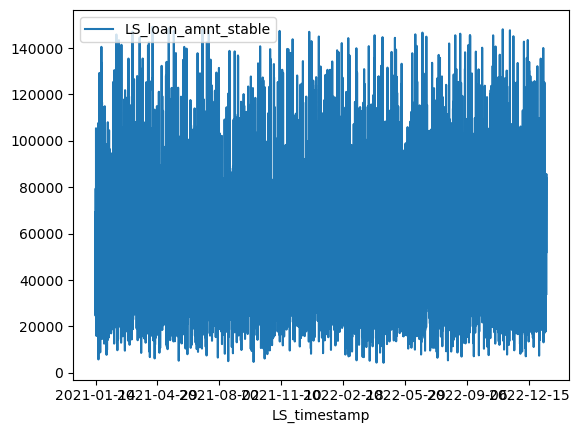

In [36]:
LS_Opening.plot(x="LS_timestamp",y="LS_loan_amnt_stable")